In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def log_results(results, filename):
    # Define the headers for your CSV file
    headers = ['Mean episodic reward', 'Critic loss', 'Actor loss']  # Add your result names here

    # Open the CSV file in 'append' mode so that existing data isn't overwritten
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        
        # Write headers if the file is empty
        if csvfile.tell() == 0:
            writer.writerow(headers)
        
        # Write the results to the CSV file
        writer.writerow(results)

In [ ]:
#IF ON COLAB
############àSEARCH HOW TO SET ON COLAB PYTHON 3.5, IF NOT IT DOES NOT WORK
!pip install gymnasium "gymnasium[classic-control,mujoco]==0.29.1"

In [2]:
#CPU set-up with GPU available: run this:
device=torch.device("cpu")
print(device)

cpu


In [ ]:
#Else:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(device))
print(device)

In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, n_actions):
        super().__init__()

        self.model = nn.Sequential(
            
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,n_actions),
            nn.Softmax()
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [4]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,64),
            nn.Tanh(),
            nn.Linear(64,1)
        )

    def forward(self,x):
        x = torch.Tensor(x)
        return self.model(x)

In [5]:
class A2C_Agent(): #this should work with more parallel environment already, not the evaluate functions

    def __init__(self, n_envs, n_steps, actor, critic, lr_actor, lr_critic):
        self.n_envs = n_envs
        self.n = n_steps
        self.actor = actor
        self.critic = critic
        self.actor_optimizer = torch.optim.Adam(actor.parameters(), lr=lr_actor)
        self.critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr_critic)
    

    def choose_action(self, states, action_type = "training"):        
        state_values = self.critic.forward(states)
        action_probs = self.actor.forward(states)
        

        if action_type == "training":
            actions_pd = torch.distributions.Categorical(probs=action_probs)
            actions = actions_pd.sample()
            actions_log_prog = actions_pd.log_prob(actions)
            return actions, actions_log_prog, state_values
        
        elif action_type == "greedy":
            actions = torch.argmax(action_probs) #greedy policy
            return actions, state_values
    
    def get_losses(self, rewards, states, next_states, log_prob, gamma, terminated):
        
        delta = torch.Tensor(rewards.reshape(self.n_envs,1)) + (1-torch.Tensor(terminated.reshape(self.n_envs,1))) * gamma * self.critic(next_states)
        advantage = delta - self.critic(states)        

        critic_loss = advantage.pow(2).mean()     
        
        actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach())).mean()

        # delta = torch.Tensor(rewards) + (1-torch.Tensor(terminated)) * gamma * self.critic(next_states)
        # advantage = delta - self.critic(states)    

        # critic_loss = advantage.pow(2)

        # actor_loss = - (advantage.detach() * log_prob.reshape_as(advantage.detach()))



        return actor_loss, critic_loss
    
    def update_params(self, critic_loss, actor_loss):
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def evaluate_performance(self):
        
        episodic_rewards_10 = []
        v_values = []
        # env = gym.vector.AsyncVectorEnv( [lambda:gym.make("CartPole-v1") for i in range(1)])
        env = gym.make("CartPole-v1")
        for j in range(10):
            state, _ = env.reset()
            total_reward = 0
            done = False
            while not done:
                action, state_values = self.choose_action(state, action_type= "greedy")
                #get the current value function fro one trajectory (j==0)
                if j ==0 : v_values.append( state_values.detach().data.numpy() ) #shitty with float
                
                #go to the next state
                next_state, reward, terminated, truncated, _  = env.step(action.detach().data.numpy())
                total_reward += reward
                state = next_state
                
                done = terminated or truncated
            episodic_rewards_10.append(total_reward)
        print("episodic return of the 20000:", np.mean(episodic_rewards_10))
        return np.mean(episodic_rewards_10), v_values
        #comment this if you are trying with more envs
        #plt.plot(v_values)
        #plt.xlabel("trajectory")
        #plt.xlabel("V lalue")
        #plt.title("V values for the first evaluation trajectory")
        #plt.savefig(f'figures/v_values_{total_steps}.png')
        #plt.close()
        print("\n")
    
    def evaluate_training(self, episode_rewards, actor_loss, critic_loss, filename):
        # print("current episodic return:", np.mean(episode_rewards))
        # print("critic loss:", (critic_loss.detach().data.numpy()))
        # print("actor loss:", (actor_loss.detach().data.numpy()))
        log_results([np.mean(episode_rewards), critic_loss.detach().data.numpy(), actor_loss.detach().data.numpy()], filename)
        # print("\n")
    


In [6]:
episode_rewards = []
v_values = []
rewards_20k = []
total_steps = 0
max_steps = 500000
env = gym.vector.AsyncVectorEnv( [lambda:gym.make("CartPole-v1") for i in range(1)])
# env = gym.make("CartPole-v1")
state_dim  = env.single_observation_space.shape[0]
n_actions = env.single_action_space.n
actor = Actor(state_dim, n_actions)
critic = Critic(state_dim)
agent = A2C_Agent(n_envs=1, n_steps=1, actor= actor, critic= critic, lr_actor=1e-5, lr_critic=1e-3)
state = env.reset()[0]
filename = '3_' + '1k_res.csv'

In [11]:
actions, actions_log_prog, state_values = agent.choose_action(state)
next_state, reward, terminated, truncated, _ = env.step(actions.numpy())
actor_loss, critic_loss = agent.get_losses([reward], state, next_state, actions_log_prog, 0.99, [terminated])
print(state, actions, actions_log_prog, state_values)
print(next_state, reward, terminated, truncated)
print(actor_loss, critic_loss)
# print(critic(state))
# print(torch.Tensor(reward.reshape(2,1)) + 0.99 * critic(next_state))

[-0.00367009 -0.03284851 -0.04717709  0.01643279] tensor(0) tensor(-0.5842, grad_fn=<SqueezeBackward1>) tensor([-0.1925], grad_fn=<ViewBackward0>)
[ 0.00098774 -0.22422294 -0.06029816  0.22688027] 1.0 False False
tensor([0.5808], grad_fn=<NegBackward0>) tensor([0.9883], grad_fn=<PowBackward0>)


In [28]:
torch.Tensor(state)

tensor([[ 0.0122,  0.0330, -0.0165, -0.0243],
        [ 0.0274,  0.0239,  0.0124, -0.0317]])

In [7]:
while total_steps < max_steps:  

    terminated = False
    ep_reward = 0
    # state = env.reset()[0]

    
    while not terminated:
        actions, actions_log_prog, state_values = agent.choose_action(state)
        
        next_state, reward, terminated, truncated, _ = env.step(actions.numpy())
        actor_loss, critic_loss = agent.get_losses(reward, state, next_state, actions_log_prog, 0.99, terminated)
        ep_reward += reward
        state = next_state

        agent.update_params(critic_loss, actor_loss)

        if (total_steps % 1000) == 0: 
            agent.evaluate_training(episode_rewards, actor_loss, critic_loss, filename)
            episode_rewards = []
        if (total_steps % 20000 == 0): 
            reward_20k, vs = agent.evaluate_performance()
            rewards_20k.append(rewards_20k)
            v_values.append(vs)


        terminated = terminated or truncated

        if total_steps >= max_steps:
            break  
        else: total_steps += 1
        
            
    episode_rewards.append(ep_reward)

/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thomasbrunet/opt/anaconda3/envs/rl_project/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


episodic return of the 20000: 9.4
episodic return of the 20000: 271.1
episodic return of the 20000: 306.4
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 332.9
episodic return of the 20000: 500.0
episodic return of the 20000: 484.5
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 500.0
episodic return of the 20000: 182.9
episodic return of the 20000: 417.4
episodic return of the 20000: 500.0
episodic return of the 20000: 294.0
episodic return of the 20000: 209.2
episodic return of the 20000: 420.7
episodic return of the 20000: 221.9
episodic return of the 20000: 500.0
episodic return of the 20000: 471.1
episodic return of the 20000: 429.5
episodic return of the 20000: 430.6
episodic return of the 20000: 476.0


<Axes: xlabel='None', ylabel='Critic loss'>

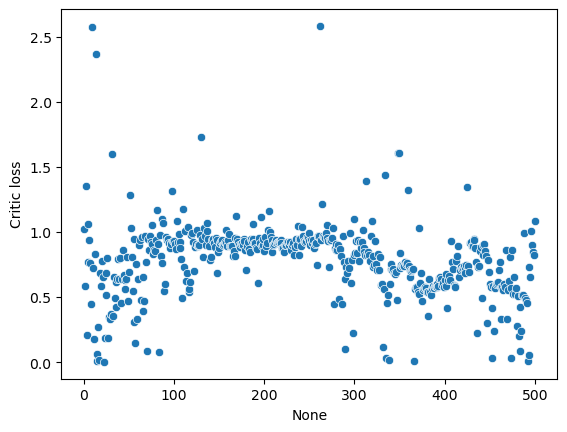

In [8]:
import pandas as pd
import seaborn as sns

data = pd.read_csv(filename)

sns.scatterplot(data, x=data.index, y='Critic loss')

<Axes: xlabel='None', ylabel='Actor loss'>

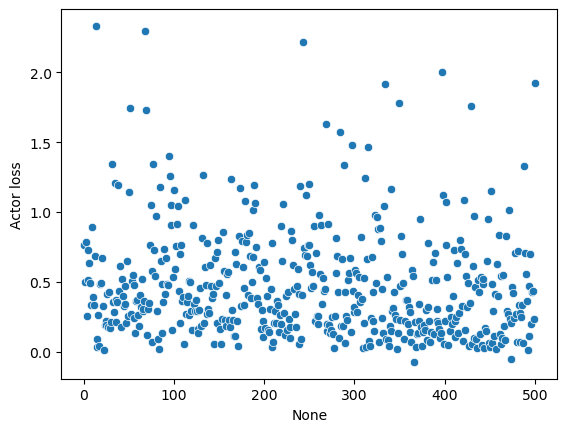

In [9]:
sns.scatterplot(data, x=data.index, y='Actor loss')

<Axes: xlabel='None', ylabel='Mean episodic reward'>

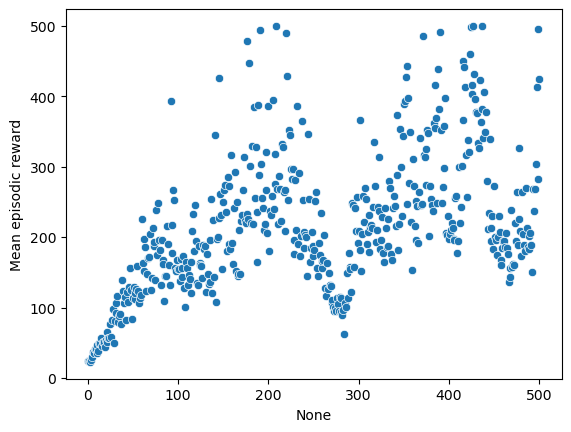

In [10]:
sns.scatterplot(data, x=data.index, y='Mean episodic reward')

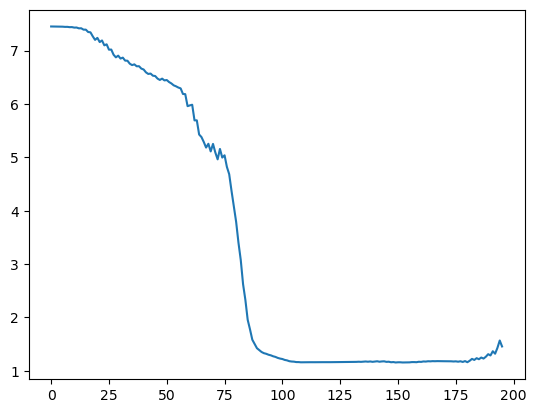

In [29]:
plt.plot(range(len(v_values[14])), v_values[14])